In [1]:
import pandas as pd

### Reading in data and splitting into train, validation, test sets

In [2]:
df = pd.read_csv("fraud_oracle.csv")

In [3]:
print(df.shape)

(15420, 33)


In [4]:
# Separate features and response
X = df.drop(columns=['FraudFound_P'])
y = df['FraudFound_P']

In [5]:
X_numeric = X.select_dtypes(include=['int64', 'float64'])

print("Original feature count:", X.shape[1])
print("Numerical feature count:", X_numeric.shape[1])
print("Numerical columns kept:", list(X_numeric.columns))

Original feature count: 32
Numerical feature count: 8
Numerical columns kept: ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year']


In [6]:
from sklearn.model_selection import train_test_split
# Split into training (80% of whole dataset) and testing (20% of whole dataset) 
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y,
    test_size=0.20,
    random_state=42,   # ensures reproducibility
    stratify=y         # preserves class balance
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (12336, 8) (12336,)
Testing set shape: (3084, 8) (3084,)


In [7]:
# Further split training into training (60% of whole dataset) and validation (20% of whole dataset) 
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train,
    test_size=0.25,
    random_state=42,   # ensures reproducibility
    stratify=y_train         # preserves class balance
)

print("Training set shape:", X_subtrain.shape, y_subtrain.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (9252, 8) (9252,)
Validation set shape: (3084, 8) (3084,)
Testing set shape: (3084, 8) (3084,)


Above, we have split the data into 60% train, 20% validation, and 20% test. 

### Function to check class proportions

In [8]:
def check_class_proportions(y):
    """
    Prints the count and proportion of each class in a pandas Series or array.
    """
    y_series = pd.Series(y, name="label")
    counts = y_series.value_counts().sort_index()
    proportions = y_series.value_counts(normalize=True).sort_index()
    
    result = pd.DataFrame({
        "count": counts,
        "proportion": proportions.round(4)
    })
    
    print(result)
    return result

## Logistic Regression (Base Model)

### Train-validation set approach

Now, we use the train-validation set approach to conduct hyperparameter tuning on the logistic regression model. The model with the combination of hyperparameters which produces the highest validation PR-AUC will be selected.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, auc
)
from itertools import product
import pandas as pd
import numpy as np

best_pr_auc = 0      
best_params = None
best_metrics = {}
best_model = None

# --- Hyperparameter grid ---
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

# --- Loop through all combinations ---
for C, penalty, solver, class_weight in product(
    param_grid['C'],
    param_grid['penalty'],
    param_grid['solver'],
    param_grid['class_weight']
):
    try:
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight=class_weight,
            max_iter=1000,
            random_state=42
        )
        model.fit(X_subtrain, y_subtrain)

        # Predict on validation set
        y_val_pred = model.predict(X_val)
        y_val_prob = model.predict_proba(X_val)[:, 1]

        # Compute metrics
        acc = accuracy_score(y_val, y_val_pred)
        prec = precision_score(y_val, y_val_pred, zero_division=0)
        rec = recall_score(y_val, y_val_pred, zero_division=0)
        f1 = f1_score(y_val, y_val_pred, zero_division=0)
        roc_auc = roc_auc_score(y_val, y_val_prob)

        # --- Compute PR-AUC ---
        precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_val_prob)
        pr_auc = auc(recall_vals, precision_vals)

        # Track best model (based on PR-AUC)
        if pr_auc > best_pr_auc:
            best_pr_auc = pr_auc
            best_params = {
                'C': C,
                'penalty': penalty,
                'solver': solver,
                'class_weight': class_weight
            }
            best_metrics = {
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1': f1,
                'ROC-AUC': roc_auc,
                'PR-AUC': pr_auc
            }
            best_model = model

    except Exception as e:
        print(f"Skipped combination (C={C}, penalty={penalty}) due to error: {e}")
        continue

# --- Summary of tuning results ---
print("\n=== Train–Validation Hyperparameter Tuning Results ===")
print("Best Parameters:", best_params)
print(f"Best PR-AUC (Validation): {best_pr_auc:.4f}\n")

print("=== Metrics for Selected Model (Optimal Hyperparameters) ===")
for metric, value in best_metrics.items():
    print(f"{metric:10s}: {value:.4f}")

# --- Classification summary  ---
print("\n=== Classification Summary for Best Model ===")
y_val_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)

report_dict = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report:\n")
display(report_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]},
     {'selector': 'td', 'props': [('text-align', 'center')]}]
).format(precision=6))




=== Train–Validation Hyperparameter Tuning Results ===
Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}
Best PR-AUC (Validation): 0.0683

=== Metrics for Selected Model (Optimal Hyperparameters) ===
Accuracy  : 0.9403
Precision : 0.0000
Recall    : 0.0000
F1        : 0.0000
ROC-AUC   : 0.5084
PR-AUC    : 0.0683

=== Classification Summary for Best Model ===
Confusion Matrix:
 [[2900    0]
 [ 184    0]]

Classification Report:



,precision,recall,f1-score,support
0,0.940337,1.000000,0.969251,2900.000000
1,0.000000,0.000000,0.000000,184.000000
accuracy,0.940337,0.940337,0.940337,0.940337
macro avg,0.470169,0.500000,0.484626,3084.000000
weighted avg,0.884234,0.940337,0.911423,3084.000000


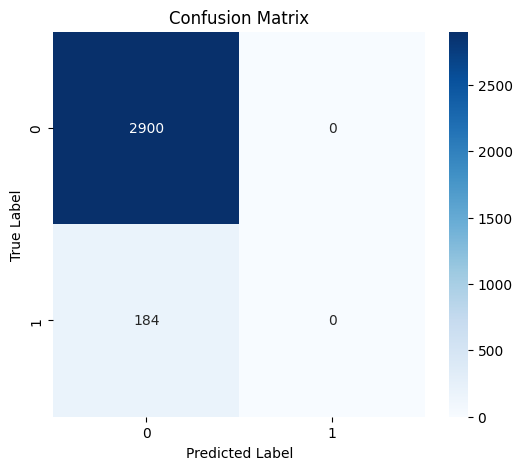

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The results of the train-validation approach suggest that the model with the hyperparameter combination: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None} is the optimal one which produces the highest validation PR-AUC.